In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt

In [2]:
NL_t = 0.4
NL_c = 0.01
NL_L = 1.8
NL_mu = 0.3

mass = 938.272045e6
ke = 2.5*1.0e6
energy = ke+mass
freq = 30*1.0e6

g = energy/mass
bg = np.sqrt(g**2-1.0)
vec = bg/g*impact.data.clight

turns = 2048

alfaEntrance = np.tan(np.pi*NL_mu)
betaEntrance = NL_L/np.sin(2.0*np.pi*NL_mu)

In [3]:
print(alfaEntrance,betaEntrance)

1.3763819204711734 1.8926320036288808


# Forward Run

In [4]:
beam = impact.getBeam()
beam.current = 0.0
beam.kinetic_energy = ke
beam.mass = mass
beam.charge = 1.0
beam.frequency = freq
beam.nCore_y = 1
beam.nCore_z = 1
beam.n_particles = 1

In [5]:
beam.distribution.distribution_type = 'Waterbag'
beam.distribution.betx  = 0.0
beam.distribution.alfx  = 0.0
beam.distribution.emitx = 0.0
beam.distribution.bety  = 0.0
beam.distribution.alfy  = 0.0
beam.distribution.emity = 0.0
beam.distribution.betz  = 0.0
beam.distribution.alfz  = 0.0
beam.distribution.emitz = 0.0

beam.distribution.offsetx = 4.0e-3
beam.distribution.offsety = 0.0

In [6]:
lattice = [impact.getElem('loop'),impact.getElem('nonlinear_insert'),impact.getElem('linear_matrix_map')] 
lattice[0].turns=turns
lattice[1].length = NL_L
lattice[1].strength_t = NL_t
lattice[1].transverse_scale_c = NL_c
lattice[1].tune_advance = NL_mu
lattice[1].n_sckick = 100
lattice[2].nonlinear_insert_length = NL_L
lattice[2].nonlinear_insert_tuneAdvance = NL_mu

writePdata = impact.getElem('write_raw_ptcl')
writePdata.file_id=-10
writePdata.turn=1
lattice.insert(1,writePdata)

writePdata1 = impact.getElem('write_raw_ptcl')
writePdata1.file_id=-11
writePdata1.turn=int(turns/2)
lattice.append(writePdata1)

elemTBT = impact.getElem('TBT')
elemTBT.file_id = 10

elemTBTint = impact.getElem('TBT_integral')
elemTBTint.strength_t = NL_t
elemTBTint.transverse_scale_c = NL_c
elemTBTint.betx = betaEntrance
elemTBTint.alfx = alfaEntrance
elemTBTint.file_id = 10

lattice.insert(1,elemTBTint)
lattice.insert(1,elemTBT)

In [7]:
impact.writeInputFile(beam,lattice)
impact.run(beam)

0

In [8]:
ind,TBT    = impact.readTBT(10,ke,mass,freq)
ind,TBTint = impact.readTBT_integral(10)

In [9]:
X=impact.readRMS('x')
Y=impact.readRMS('y')

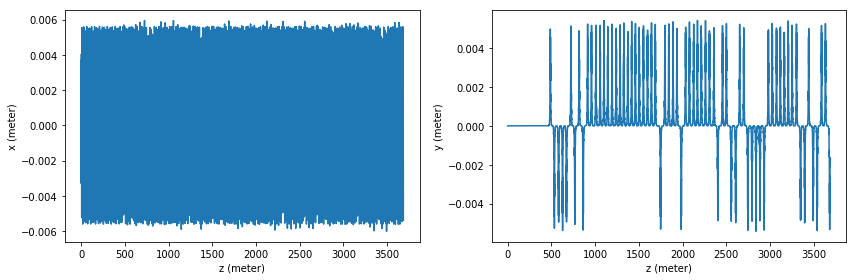

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(X.s,X.centroid_x)
plt.xlabel('z (meter)')
plt.ylabel('x (meter)')
plt.subplot(1,2,2)
plt.xlabel('z (meter)')
plt.ylabel('y (meter)')
plt.plot(Y.s,Y.centroid_y)
plt.tight_layout()
plt.savefig('xoffset4mm.yoffset100micro.png',dpi=180)

0.15820516506670956 0.5625036509084036


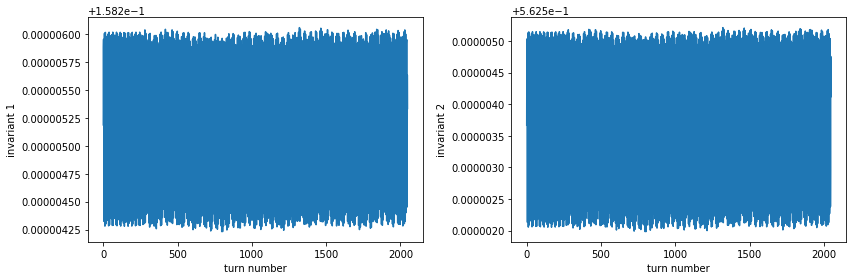

In [11]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(TBTint[:,0])
plt.xlabel('turn number')
plt.ylabel('invariant 1')
plt.subplot(1,2,2)
plt.xlabel('turn number')
plt.ylabel('invariant 2')
plt.plot(TBTint[:,1])
plt.tight_layout()
plt.savefig('invarinats.xoffset4mm.yoffset100micro.png',dpi=180)
print(np.mean(TBTint[:,0]),np.mean(TBTint[:,1]))

In [12]:
X = TBT[:,0,0] - 1j*TBT[:,1,0]
Y = TBT[:,2,0] - 1j*TBT[:,3,0]
tuneX1,amp,dummy = impact.util.naff(1,X[:1024])
tuneX2,amp,dummy = impact.util.naff(1,X[1024:])
tuneY1,amp,dummy = impact.util.naff(1,Y[:1024])
tuneY2,amp,dummy = impact.util.naff(1,Y[1024:])

In [13]:
# print(tuneX1-tuneX2)
# print(tuneY1-tuneY2)

# Backward Run

In [14]:
latticeB = [impact.getElem('loop'),impact.getElem('linear_matrix_map'),impact.getElem('nonlinear_insert')] 
latticeB[0].turns  =  int(turns/2)
latticeB[2].length = -NL_L
latticeB[2].strength_t = NL_t
latticeB[2].transverse_scale_c = NL_c
latticeB[2].tune_advance = NL_mu
latticeB[2].n_sckick = 100
latticeB[1].nonlinear_insert_length = -NL_L
latticeB[1].nonlinear_insert_tuneAdvance = -NL_mu

writePdata = impact.getElem('write_raw_ptcl')
writePdata.file_id=-20
writePdata.turn=1
latticeB.insert(1,writePdata)

writePdata1 = impact.getElem('write_raw_ptcl')
writePdata1.file_id=-21
writePdata1.turn=int(turns/2)
latticeB.append(writePdata1)

elemTBT = impact.getElem('TBT')
elemTBT.file_id = 20

latticeB.append(elemTBT)

beam.distribution.distribution_type = 'ReadFile_binary'
beam.distribution.file_id = 11

In [15]:
impact.writeInputFile(beam,latticeB)
impact.run()

0

In [16]:
iTBT,TBTF = impact.readTBT(10,ke,mass,freq)
iTBT,TBTB = impact.readTBT(20,ke,mass,freq)

In [17]:
TBTF = TBTF[:int(turns/2),:,0]
TBTB = TBTB[::-1,:,0]

In [18]:
n=-1
print(TBTF[n,:],TBTB[n,:])

[ 0.00171384  0.00247455  0.00468714 -0.00314949  0.          0.        ] [ 0.00171384  0.00247455  0.00468714 -0.00314949  0.          0.        ]


In [19]:
XF = TBTF[:,0] - 1j*TBTF[:,1]
XB = TBTB[:,0] - 1j*TBTB[:,1]
YF = TBTF[:,2] - 1j*TBTF[:,3]
YB = TBTB[:,2] - 1j*TBTB[:,3]

In [20]:
diff = np.sqrt(np.sum(np.abs(XF-XB)**2+np.abs(YF-YB)**2)/1024)
print(diff)

0.005812856267236242


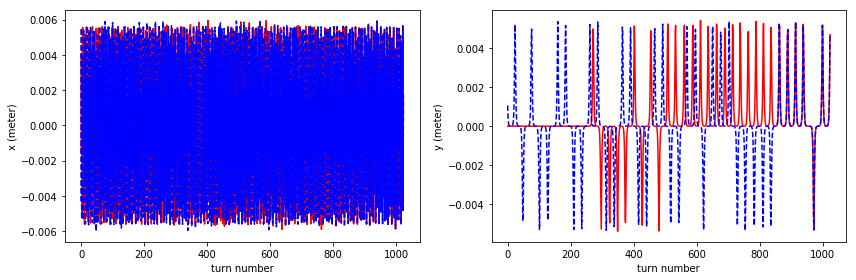

In [21]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(np.real(XF),'r')
plt.plot(np.real(XB),'b--')
plt.xlabel('turn number')
plt.ylabel('x (meter)')
plt.subplot(1,2,2)
plt.xlabel('turn number')
plt.ylabel('y (meter)')
plt.plot(np.real(YF),'r')
plt.plot(np.real(YB),'b--')
plt.tight_layout()
plt.savefig('xoffset4mm.forward-backward.png',dpi=180)